In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import cv2 as cv
import os
import time

In [2]:
'''
# I Machine learning, 
extraction des features avec SIFT
création des bag-of-features
classification supervisée

# II Deep learning
'''

'\n# I Machine learning, \nextraction des features avec SIFT\ncréation des bag-of-features\nclassification supervisée\n\n# II Deep learning\n'

# Sommaire <a class='anchor' id='S'></a>

## [I, Chargement et préparation des données](#I)

## [II, Mise en place d'un classificateur basé sur les features](#II)
### [A, Selection des features](#IIA)
### [B, Création des clusters pour les features](#IIB)
### [C, Réduction de dimensions et visualisation](#IIC)
### [D, Prédiction du modèle](#IID)

## [III, Approche par les réseaux de neurones](#III)
### [A, CNN classique](#IIIA)
### [B, CNN avec data augmentation](#IIIB)
### [C, CNN avec transfer learning](#IIIC)


# I, Chargement et préparation des données <a class='anchor' id='I'></a>

### Chargement du dataframe

In [3]:
data = pd.read_csv('flipkart_com-ecommerce_sample_1050.csv', index_col=[0], parse_dates=[1])

In [4]:
data.sample(3)

,crawl_timestamp,product_url,product_name,product_category_tree,pid,retail_price,discounted_price,image,is_FK_Advantage_product,description,product_rating,overall_rating,brand,product_specifications
uniq_id,,,,,,,,,,,,,,
ae45b64d808a883aa35f2bf4de879cac,2016-04-21 20:34:29+00:00,http://www.flipkart.com/vitamins-embroidered-b...,Vitamins Embroidered Baby Girl's Denim Shorts,"[""Baby Care >> Infant Wear >> Baby Girls' Clot...",SRTEHHXGEVDQMEQV,949.0,949.0,ae45b64d808a883aa35f2bf4de879cac.jpg,False,Specifications of Vitamins Embroidered Baby Gi...,No rating available,No rating available,Vitamins,"{""product_specification""=>[{""key""=>""Ideal For""..."
5531b9f454e2d75cfe00c3f795e06de5,2015-12-01 12:40:44+00:00,http://www.flipkart.com/rockmantra-vintage-min...,Rockmantra Vintage Mini Leafs Ceramic Mug,"[""Kitchen & Dining >> Coffee Mugs >> Rockmantr...",MUGEAGGKFYN8F5TT,499.0,199.0,5531b9f454e2d75cfe00c3f795e06de5.jpg,False,Rockmantra Vintage Mini Leafs Ceramic Mug (5.5...,No rating available,No rating available,NaN,"{""product_specification""=>[{""key""=>""Type"", ""va..."
5db6bd89da44841c1a5b686e67137704,2016-01-07 05:50:25+00:00,http://www.flipkart.com/sonata-1141ym22-analog...,Sonata 1141YM22 Analog Watch - For Men,"[""Watches >> Wrist Watches >> Sonata Wrist Wat...",WATDZ2ZQGTENGJDH,999.0,949.0,5db6bd89da44841c1a5b686e67137704.jpg,False,Sonata 1141YM22 Analog Watch - For Men - Buy ...,No rating available,No rating available,NaN,"{""product_specification""=>[{""key""=>""Type"", ""va..."


In [5]:
data = data.loc[:,['image', 'product_category_tree']]

In [6]:
data = pd.concat([data, data['product_category_tree'].str.split(' >> ', 4, expand=True)], axis=1)

In [7]:
data[0] = data[0].str.replace('^\["', '', regex=True)
data[3] = data[3].str.replace('"]', '', regex=True)
data[4] = data[4].str.replace('"]', '', regex=True)

In [8]:
data.rename(columns={0 : 'categorie'}, inplace=True)

In [9]:
data = data.loc[:,['image', 'categorie']]

In [10]:
data.reset_index(inplace=True, drop=True)

In [11]:
from sklearn.preprocessing import LabelEncoder

lb = LabelEncoder()
data['cat_lb'] = lb.fit_transform(data.categorie)

In [12]:
data.groupby('categorie').count()

,image,cat_lb
categorie,,
Baby Care,150,150
Beauty and Personal Care,150,150
Computers,150,150
Home Decor & Festive Needs,150,150
Home Furnishing,150,150
Kitchen & Dining,150,150
Watches,150,150


### Chargement des images

In [13]:
path = 'Images'
images = []
class_names = data.image

In [14]:
for cl in class_names:
    img_cur = cv.imread(f'{path}/{cl}', cv.IMREAD_GRAYSCALE)
    images.append(img_cur)

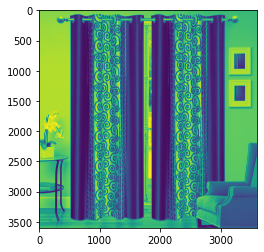

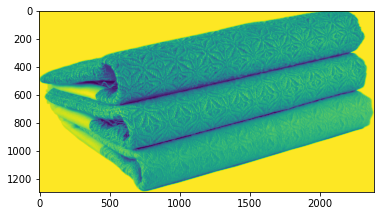

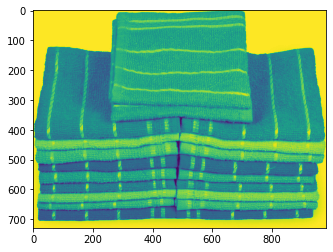

In [15]:
for img in images[:3]:
    plt.imshow(img)
    plt.savefig("random_images.png", bbox_inches='tight', transparent=True)
    plt.show()

### Pré-traitement sur les images

In [16]:
for img in images:
    img = cv.equalizeHist(img)

##### [sommaire](#S)

# II, Mise en place d'un classificateur basé sur les features <a class='anchor' id='II'></a>

## A, Selection des features <a class='anchor' id='IIA'></a>

In [104]:
images2 = images[:]

In [105]:
sift_keypoints = []
img_keypoints = []
temps1 = time.time()

sift = cv.SIFT_create(500)

for img in images2:
    kp, des = sift.detectAndCompute(img, None)
    sift_keypoints.append(des)
    img_keypoints.append(cv.drawKeypoints(img, kp, None, flags=cv.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS))
print("Duration :", time.time()-temps1)

Duration : 686.3595054149628


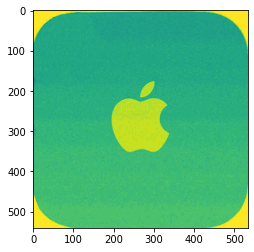

In [19]:
plt.imshow(images[343])
plt.savefig("image_sans_feature.png", bbox_inches='tight', transparent=True)
plt.show()

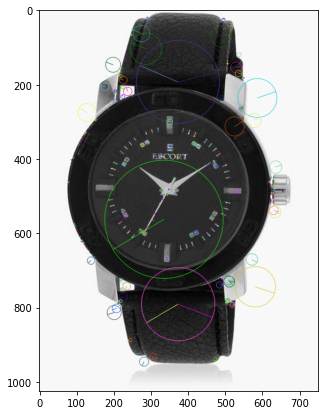

In [112]:
plt.figure(figsize=(7,7))
plt.imshow(img_keypoints[15])
#plt.savefig("image_avec_feature.png", bbox_inches='tight', transparent=True)
plt.show()

In [20]:
sift_keypoints.pop(343)

In [21]:
data2 = data.copy()

In [22]:
data = data[data.index != 343]

In [23]:
data.reset_index(inplace=True, drop=True)

In [24]:
sift_keypoints_all = np.concatenate(sift_keypoints, axis=0)
print("nombre de descripteur :", sift_keypoints_all.shape)

nombre de descripteur : (479178, 128)


##### [sommaire](#S)

## B, Création des clusters pour les features <a class='anchor' id='IIB'></a>

In [25]:
from sklearn.cluster import KMeans, MiniBatchKMeans

temps1 = time.time()

#k = int(round(np.sqrt(len(sift_keypoints_all)),0))
k = 140

print("Nombre de K : ", k)

kmeans = MiniBatchKMeans(n_clusters=k, batch_size=20000)
kmeans.fit(sift_keypoints_all)
print("Duration :", time.time()-temps1)

Nombre de K :  140
Duration : 18.678999662399292


In [26]:
def build_histogram(kmeans, des, image_num):
    res = kmeans.predict(des)
    hist = np.zeros(len(kmeans.cluster_centers_))
    nb_des=len(des)
    if nb_des==0 : print("problème histogramme image  : ", image_num)
    for i in res:
        hist[i] += 1.0/nb_des
    return hist

In [27]:
hist_vectors = []

for i, image_desc in enumerate(sift_keypoints):
    if i%100 == 0:
        print(i)
    hist = build_histogram(kmeans, image_desc, i)
    hist_vectors.append(hist)

0
100
200
300
400
500
600
700
800
900
1000


In [28]:
im_features = np.asarray(hist_vectors)

In [29]:
df = pd.DataFrame(im_features)

In [30]:
import seaborn as sns

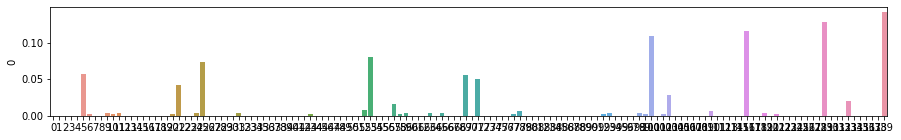

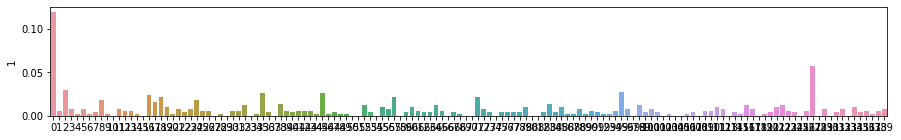

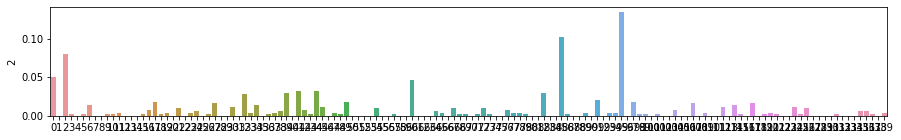

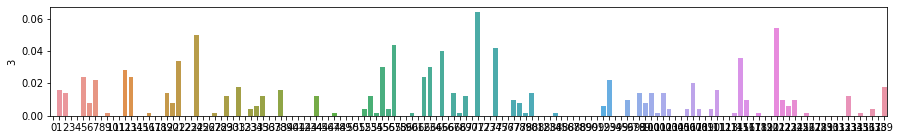

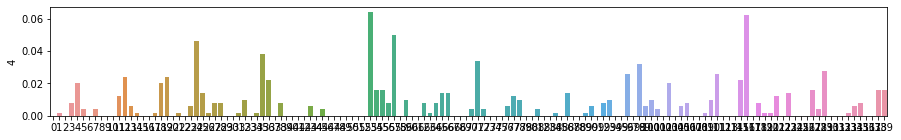

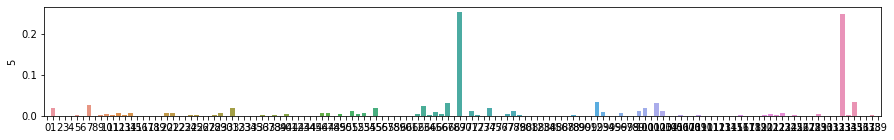

In [114]:
for i in range(df.loc[:5,:].shape[0]):
    plt.figure(figsize=(15,2))
    sns.barplot(x=df.columns, y=df.loc[i,:])
    plt.savefig("histogrammes_"+str(i)+".png", bbox_inches='tight', transparent=True)
    plt.show()

In [32]:
data.head()

,image,categorie,cat_lb
0,55b85ea15a1536d46b7190ad6fff8ce7.jpg,Home Furnishing,4
1,7b72c92c2f6c40268628ec5f14c6d590.jpg,Baby Care,0
2,64d5d4a258243731dc7bbb1eef49ad74.jpg,Baby Care,0
3,d4684dcdc759dd9cdf41504698d737d8.jpg,Home Furnishing,4
4,6325b6870c54cd47be6ebfbffa620ec7.jpg,Home Furnishing,4


##### [sommaire](#S)

### C, Réduction de dimensions et visualisation <a class='anchor' id='IIC'></a>

### Réduction de dimension par PCA

In [33]:
from sklearn.decomposition import PCA

print("Dimensions dataset avant réduction PCA : ", im_features.shape)
pca = PCA(n_components=0.99)
feat_pca= pca.fit_transform(im_features)
print("Dimensions dataset après réduction PCA : ", feat_pca.shape)

Dimensions dataset avant réduction PCA :  (1049, 140)
Dimensions dataset après réduction PCA :  (1049, 111)


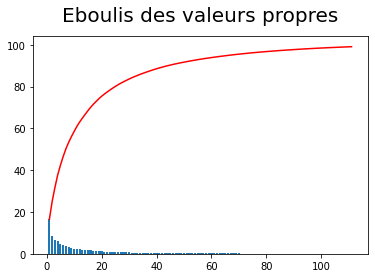

In [34]:
# Eboulis des valeurs propres

scree = pca.explained_variance_ratio_*100
plt.bar(np.arange(len(scree))+1, scree)
plt.plot(np.arange(len(scree))+1, scree.cumsum(), c='red')
plt.title("Eboulis des valeurs propres", fontsize=20, pad=15)
plt.savefig("features_eboulis.png", bbox_inches='tight', transparent=True)
plt.show()

In [35]:
pd.DataFrame(feat_pca)

,0,1,2,3,4,5,6,7,8,9,...,101,102,103,104,105,106,107,108,109,110
0,-0.045027,0.042610,-0.027818,-0.057458,-0.058475,-0.054186,-0.007700,0.005908,0.046011,-0.032663,...,-0.015125,-0.002335,-0.001194,0.002579,-0.005332,0.001307,0.006375,0.003080,-0.009835,-0.009503
1,-0.029876,-0.054576,-0.064327,0.036297,0.009634,-0.040802,0.010092,0.010421,-0.026593,-0.006155,...,0.001579,0.000218,-0.004825,0.003417,0.001405,0.002012,-0.002470,0.009584,0.004302,0.000137
2,0.012414,-0.059834,-0.039134,0.025846,0.014796,-0.003725,0.007680,-0.031857,-0.060324,-0.032701,...,-0.001525,0.000060,0.000238,-0.000340,0.005286,-0.008422,-0.002902,0.003032,-0.001492,-0.002924
3,-0.039783,0.083722,-0.010258,0.012959,0.001639,-0.029526,-0.009578,0.009809,-0.013146,-0.003949,...,-0.003523,0.005311,0.004444,0.003776,-0.000257,0.001496,0.004881,0.001863,-0.000858,-0.005363
4,-0.054335,0.025225,0.002235,-0.019392,0.025472,-0.007174,-0.019963,0.014092,-0.000440,-0.013822,...,-0.000056,-0.002930,0.004602,-0.000986,-0.003398,-0.008847,-0.003473,-0.008975,0.004868,0.003239
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1044,-0.042854,-0.051702,0.004321,0.017758,0.002573,0.015416,-0.015483,0.007170,-0.008670,0.000952,...,0.004207,-0.001659,-0.000618,0.002396,-0.003822,-0.000883,0.002433,0.005933,0.001046,-0.007046
1045,0.007935,-0.022391,-0.023574,-0.003842,-0.006876,-0.005360,-0.002895,-0.007471,-0.002824,0.012421,...,-0.006600,0.000350,-0.012235,0.002713,0.009072,0.004768,-0.004038,0.001191,0.003594,0.001577
1046,-0.053053,-0.022987,0.031253,-0.001665,-0.002100,0.023069,-0.008137,0.019756,0.003765,-0.000956,...,-0.006317,0.000529,-0.000368,-0.006724,-0.005573,0.001374,-0.006231,0.002223,-0.005817,-0.001133
1047,0.015916,-0.128062,-0.143450,0.105900,-0.008229,-0.052927,0.011967,0.043408,0.008417,0.026616,...,-0.002082,-0.000946,-0.005297,0.004553,0.000030,-0.000238,-0.000411,-0.000469,0.006898,0.001729


In [36]:
feat_pca = feat_pca[:,:30]

In [37]:
acp = pca.transform(im_features)

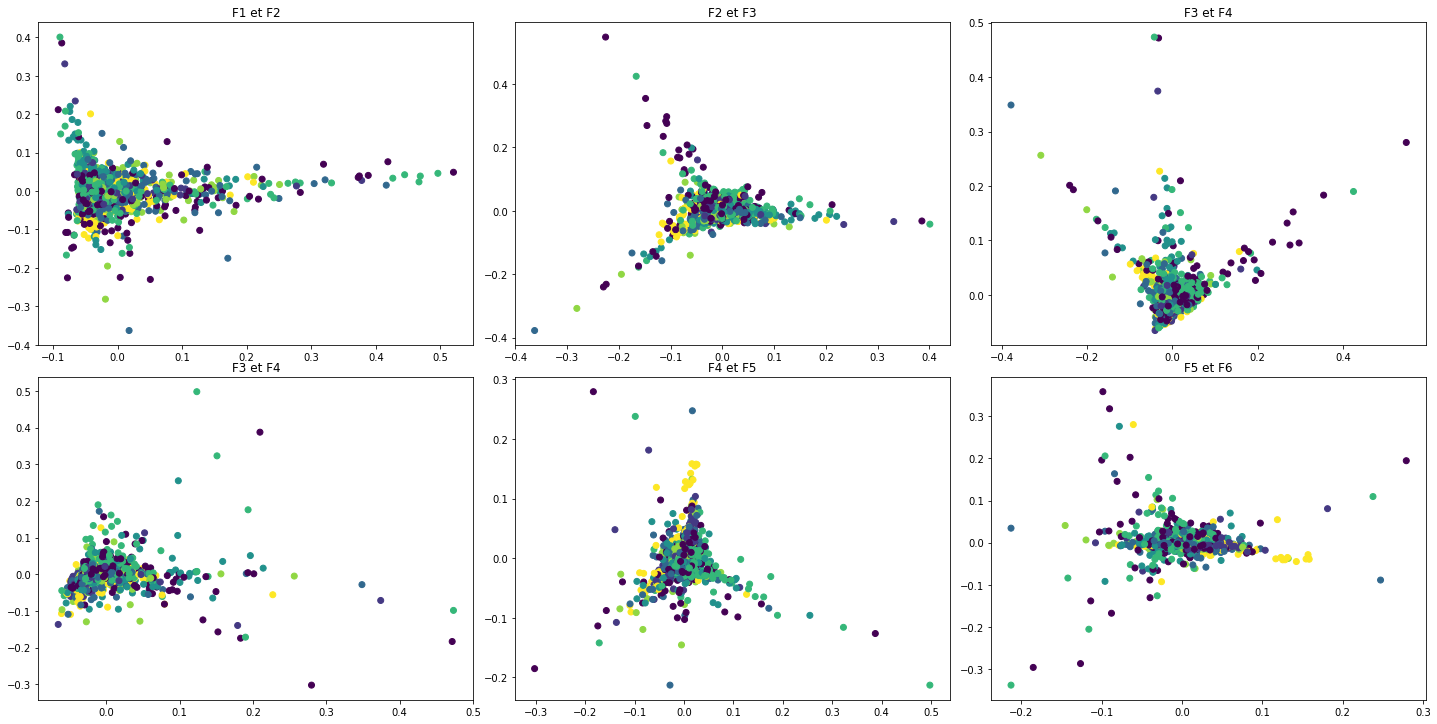

In [38]:
f, ax = plt.subplots(nrows=2, ncols=3, figsize=(20,10))
f.tight_layout()
for i in np.arange(3):
    ax[0,i].scatter(acp[:,i], acp[:,i+1], c=data.cat_lb)
    ax[0,i].title.set_text('F{} et F{}'.format(i+1, i+2))
    ax[1,i].scatter(acp[:,[3+i]], acp[:,[4+i]], c=data.cat_lb)
    ax[1,i].title.set_text('F{} et F{}'.format(3+i, 4+i))
plt.savefig("features_acp_kmean.png", bbox_inches='tight', transparent=True)
plt.show()

In [39]:
print("On passe de {} features à {} composantes principales. Ce qui explique {}% de la variance des composantes."
      .format(im_features.shape[1], feat_pca.shape[1], round(scree[:30].cumsum()[-1],0)))

On passe de 140 features à 30 composantes principales. Ce qui explique 84.0% de la variance des composantes.


In [40]:
scree[:30].cumsum()[-1]

83.56659498923098

In [41]:
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2)
X_embedded = tsne.fit_transform(feat_pca)
tsn = pd.DataFrame(X_embedded)

C:\ProgramData\Anaconda3\envs\tf-gpu\lib\site-packages\sklearn\manifold\_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
C:\ProgramData\Anaconda3\envs\tf-gpu\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


In [42]:
tsn['cat'] = data.categorie
tsn['cat_lb'] = data.cat_lb

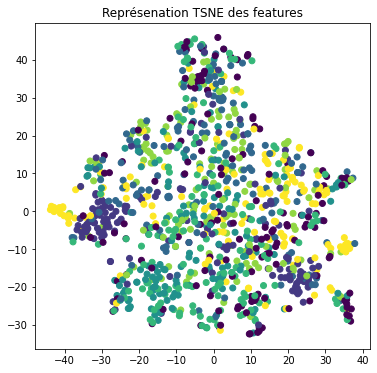

In [43]:
f, ax = plt.subplots(figsize=(6,6))
ax.scatter(tsn.loc[:,0], tsn.loc[:,1], c=tsn.cat_lb)

plt.title('Représenation TSNE des features')
plt.savefig("features_tsne.png", bbox_inches='tight', transparent=True)
#for i,txt in enumerate(tsn.index)
#    ax.annotate(txt, (tsn.iloc[i,0], tsn.iloc[i,1]))
plt.show()

On voit que le TSNE n'arrive pas à séparer les catégories d'objet.<br/>
Nous allons néanmoins demander des prédictions au modèle afin de voir son taux de succès.

##### [sommaire](#S)

## D, Prédiction du modèle <a class='anchor' id='IID'></a>

In [44]:
cls = KMeans(n_clusters=7)
cls.fit(X_embedded)

tsn['prediction'] = cls.labels_

In [45]:
from sklearn.metrics import confusion_matrix, adjusted_rand_score

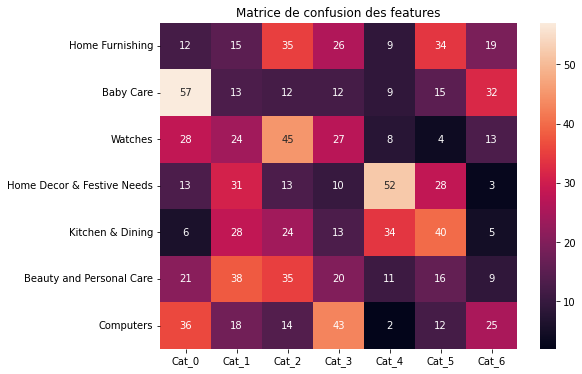

In [46]:
cm = confusion_matrix(tsn.cat_lb, tsn.prediction)

plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True)
plt.yticks(np.arange(7)+0.5,list(tsn.cat.unique()), rotation='horizontal')
plt.xticks(np.arange(7)+0.5, ['Cat_' + str(i) for i in range(7)])
plt.title('Matrice de confusion des features')
plt.savefig("features_matrix.png", bbox_inches='tight', transparent=True)
plt.show()

In [47]:
adjusted_rand_score(tsn.cat_lb, tsn.prediction)

0.05237389157757507

On voit que cette approche donne des résultats très décevants. <br/>
Avec cette méthode on ne peut pas mettre en place de moteur de classification.<br/>
Nous allons essayer des modèles basées sur les réseaux de neurone.

##### [sommaire](#S)

# III, Approche par les réseaux de neurones <a class='anchor' id='III'></a>

## A, CNN classique <a class='anchor' id='IIIA'></a>

#### Préparation des données

In [2]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models

In [49]:
path = 'Images'
images_rgb = []
class_names = data2.image

In [50]:
for cl in class_names:
    img_cur = cv.imread(f'{path}/{cl}')
    images_rgb.append(img_cur)

plt.imshow(images_rgb[10])
plt.savefig("cnn_image_normal.png", bbox_inches='tight', transparent=True)
plt.show()

In [52]:
len(images_rgb)

1050

In [53]:
data.cat_lb.values

array([4, 0, 0, ..., 0, 0, 0])

In [54]:
X = images_rgb
y = data.cat_lb.values

In [55]:
min_width = 10000
min_height = 10000

for i in range(len(images_rgb)):
    if images_rgb[i].shape[0] < min_width:
        min_width = images_rgb[i].shape[0]
    if images_rgb[i].shape[1] < min_height:
        min_height = images_rgb[i].shape[1]
        
print("Minimum weight on the dataset :", min_width)
print("Minimum height on the dataset :", min_height)

Minimum weight on the dataset : 160
Minimum lenght on the dataset : 145


In [8]:
#min_width = 160
#min_height = 145

In [57]:
dim = (min_width, min_height)
images_resized = images_rgb.copy()

for i in range(len(images_rgb)):
    images_resized[i] = cv.resize(images_resized[i], dim, interpolation = cv.INTER_AREA)
    

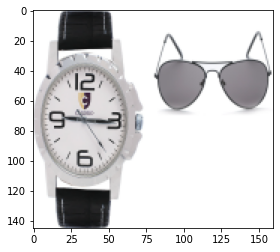

In [58]:
plt.imshow(images_resized[10])
plt.savefig("cnn_image_reshape.png", bbox_inches='tight', transparent=True)
plt.show()

In [59]:
X = images_resized
y = data2.cat_lb.values

In [60]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [61]:
unique, counts = np.unique(y_train, return_counts=True)
unique, counts

(array([0, 1, 2, 3, 4, 5, 6]),
 array([114, 126, 117, 122, 116, 122, 123], dtype=int64))

In [62]:
X_train = np.array(X_train)
X_test = np.array(X_test)

In [63]:
X_train = X_train / 255
X_test = X_test / 255

In [64]:
X_train = tf.stack(X_train)
X_test = tf.stack(X_test)

In [65]:
X_train.shape

TensorShape([840, 145, 160, 3])

In [66]:
y_train.shape

(840,)

#### Mise en place du réseau de neurones

In [3]:
cnn = models.Sequential([
    #cnn
    layers.Conv2D(filters=16, kernel_size=(3,3), activation='relu',  padding='same', strides=(1,1) ,input_shape=(145,160,3)),
    layers.AvgPool2D((2,2)),    
    
    layers.Conv2D(filters=32, kernel_size=(3,3), activation='relu',  padding='same', strides=(1,1)),
    layers.AvgPool2D((2,2)),
    
    layers.Conv2D(filters=64, kernel_size=(3,3), activation='relu'),
    layers.AvgPool2D((2,2)),
    
    #dense
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dense(7, activation='softmax')
])

In [4]:
cnn.compile(optimizer='adam', 
           loss='sparse_categorical_crossentropy',
           metrics=['accuracy'])

In [5]:
cnn.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 145, 160, 16)      448       
_________________________________________________________________
average_pooling2d (AveragePo (None, 72, 80, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 72, 80, 32)        4640      
_________________________________________________________________
average_pooling2d_1 (Average (None, 36, 40, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 34, 38, 64)        18496     
_________________________________________________________________
average_pooling2d_2 (Average (None, 17, 19, 64)        0         
_________________________________________________________________
flatten (Flatten)            (None, 20672)             0

In [69]:
cnn.fit(X_train, y_train, epochs=20)

Epoch 1/20
27/27 [==============================] - 12s 44ms/step - loss: 1.9059 - accuracy: 0.2381
Epoch 2/20
27/27 [==============================] - 1s 35ms/step - loss: 1.5786 - accuracy: 0.4179
Epoch 3/20
27/27 [==============================] - 1s 35ms/step - loss: 1.2989 - accuracy: 0.5155
Epoch 4/20
27/27 [==============================] - 1s 36ms/step - loss: 1.0796 - accuracy: 0.6190
Epoch 5/20
27/27 [==============================] - 1s 36ms/step - loss: 0.8402 - accuracy: 0.6857
Epoch 6/20
27/27 [==============================] - 1s 36ms/step - loss: 0.6377 - accuracy: 0.7762
Epoch 7/20
27/27 [==============================] - 1s 35ms/step - loss: 0.4615 - accuracy: 0.8560
Epoch 8/20
27/27 [==============================] - 1s 35ms/step - loss: 0.3471 - accuracy: 0.8964
Epoch 9/20
27/27 [==============================] - 1s 35ms/step - loss: 0.2477 - accuracy: 0.9214
Epoch 10/20
27/27 [==============================] - 1s 35ms/step - loss: 0.2648 - accuracy: 0.9143
Epoch 11

#### Prédictions

In [70]:
cnn.evaluate(X_test, y_test)

7/7 [==============================] - 0s 39ms/step - loss: 5.1208 - accuracy: 0.5286


[5.120820999145508, 0.5285714268684387]

In [71]:
y_pred = cnn.predict(X_test)

In [72]:
y_predicted = []

for i in range(len(y_pred)):
    y_predicted.append(np.argmax(y_pred[i]))

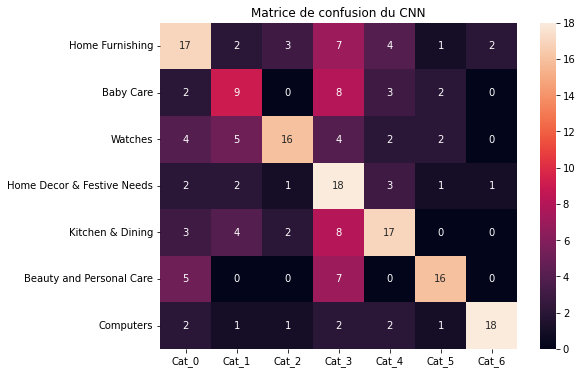

In [73]:
cm = confusion_matrix(y_test, y_predicted)

plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True)
plt.yticks(np.arange(7)+0.5,list(tsn.cat.unique()), rotation='horizontal')
plt.xticks(np.arange(7)+0.5, ['Cat_' + str(i) for i in range(7)])
plt.title('Matrice de confusion du CNN')
plt.savefig("cnn_matrix.png", bbox_inches='tight', transparent=True)
plt.show()

In [74]:
adjusted_rand_score(y_test, y_predicted)

0.19016225678314144

Malgré un entrainement concluant (+98% de résultat positif), les prédictions restent trop faibles (+50% de résultats bons).. <br/>
La matrice de confusion illustre bien cela : certes une diagonale se dessine mais elles n'est pas nette.

##### [sommaire](#S)

## B, CNN avec data augmentation <a class='anchor' id='IIIB'></a>

In [9]:
data_augmentation = keras.Sequential([
    layers.experimental.preprocessing.RandomFlip('horizontal', input_shape=(min_height, min_width, 3)),
    layers.experimental.preprocessing.RandomRotation(0.1),
    layers.experimental.preprocessing.RandomZoom(0.1),
])

In [10]:
cnn_da = models.Sequential([
    data_augmentation,
    #cnn
    layers.Conv2D(filters=16, kernel_size=(3,3), activation='relu',  padding='same', strides=(1,1) ,input_shape=(145,160,3)),
    layers.AvgPool2D((2,2)),    
    
    layers.Conv2D(filters=32, kernel_size=(3,3), activation='relu',  padding='same', strides=(1,1)),
    layers.AvgPool2D((2,2)),
    
    layers.Conv2D(filters=64, kernel_size=(3,3), activation='relu'),
    layers.AvgPool2D((2,2)),
    
    layers.Dropout(0.2),
    
    #dense
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dense(7, activation='softmax')
])

cnn_da.compile(optimizer='adam', 
           loss='sparse_categorical_crossentropy',
           metrics=['accuracy'])

In [11]:
cnn_da.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential_1 (Sequential)    (None, 145, 160, 3)       0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 145, 160, 16)      448       
_________________________________________________________________
average_pooling2d_3 (Average (None, 72, 80, 16)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 72, 80, 32)        4640      
_________________________________________________________________
average_pooling2d_4 (Average (None, 36, 40, 32)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 34, 38, 64)        18496     
_________________________________________________________________
average_pooling2d_5 (Average (None, 17, 19, 64)       

In [77]:
cnn_da.fit(X_train, y_train, epochs=50, verbose=0)

In [78]:
cnn_da.evaluate(X_test, y_test)

7/7 [==============================] - 0s 17ms/step - loss: 2.6146 - accuracy: 0.4714


[2.614565849304199, 0.4714285731315613]

In [79]:
y_pred = cnn_da.predict(X_test)

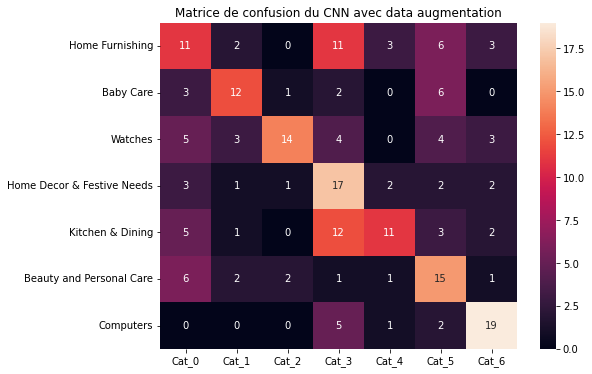

In [80]:
y_predicted = []

for i in range(len(y_pred)):
    y_predicted.append(np.argmax(y_pred[i]))
    
cm = confusion_matrix(y_test, y_predicted)

plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True)
plt.yticks(np.arange(7)+0.5,list(tsn.cat.unique()), rotation='horizontal')
plt.xticks(np.arange(7)+0.5, ['Cat_' + str(i) for i in range(7)])
plt.title('Matrice de confusion du CNN avec data augmentation')
plt.savefig("cnn_da_matrix.png", bbox_inches='tight', transparent=True)
plt.show()

In [81]:
adjusted_rand_score(y_test, y_predicted)

0.14991544762972325

La technique des data augmentation permet d'augmenter les résultats des prévisions. <br/>
Cependant, celles-ci ne sont encore pas assez bonnes pour servir de modèle.

##### [sommaire](#S)

## C, CNN avec transfer learning <a class='anchor' id='IIIC'></a>

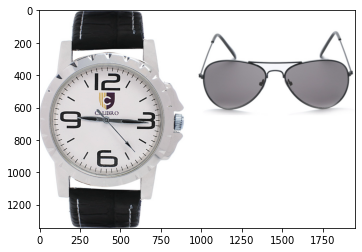

In [82]:
plt.imshow(images_rgb[10])

In [83]:
dim = (224, 224)
images_resized = images_rgb.copy()

for i in range(len(images_rgb)):
    images_resized[i] = cv.resize(images_resized[i], dim, interpolation = cv.INTER_AREA)

In [84]:
import pickle

with open('images_resized.txt', 'wb') as fp:
    pickle.dump(images_resized, fp)

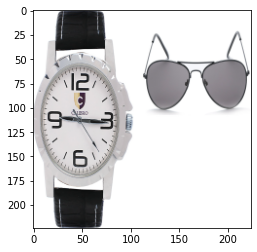

In [85]:
plt.imshow(images_resized[10])
plt.savefig("cnn_tl_image_reshape.png", bbox_inches='tight', transparent=True)
plt.show()

In [86]:
from sklearn.model_selection import train_test_split

X = images_resized
y = data2.cat_lb.values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

In [87]:
unique, counts = np.unique(y_train, return_counts=True)
unique, counts

(array([0, 1, 2, 3, 4, 5, 6]),
 array([ 99, 108,  99, 113, 106, 107, 103], dtype=int64))

In [88]:
X_train = np.array(X_train)
X_test = np.array(X_test)

In [89]:
X_train = X_train / 255
X_test = X_test / 255

In [90]:
X_train.shape, y_train.shape

((735, 224, 224, 3), (735,))

In [12]:
from keras.applications.vgg16 import VGG16
from keras.models import Model

In [13]:
vgg = VGG16(input_shape=(224,224,3), weights='imagenet', include_top=False)

In [14]:
for layer in vgg.layers:
    layer.trainable=False 

In [15]:
x = layers.Flatten()(vgg.output)
prediction = layers.Dense(7, activation='softmax')(x)

In [16]:
cnn_tl = Model(inputs=vgg.input, outputs=prediction)

In [17]:
cnn_tl.compile(optimizer='adam', 
           loss='sparse_categorical_crossentropy',
           metrics=['accuracy'])

In [18]:
cnn_tl.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

In [97]:
cnn_tl.fit(X_train, y_train, epochs=3)

Epoch 1/3
23/23 [==============================] - 20s 570ms/step - loss: 1.3025 - accuracy: 0.5891
Epoch 2/3
23/23 [==============================] - 7s 302ms/step - loss: 0.3095 - accuracy: 0.8871
Epoch 3/3
23/23 [==============================] - 7s 303ms/step - loss: 0.0909 - accuracy: 0.9837


In [98]:
cnn_tl.evaluate(X_test, y_test)

10/10 [==============================] - 9s 904ms/step - loss: 0.6335 - accuracy: 0.8032


[0.6335428357124329, 0.803174614906311]

In [99]:
cnn_tl.save('cnn_tl/save')

INFO:tensorflow:Assets written to: cnn_tl/save\assets


In [100]:
y_pred = cnn_tl.predict(X_test)

In [101]:
tsn = pd.DataFrame()
tsn['cat'] = data.categorie

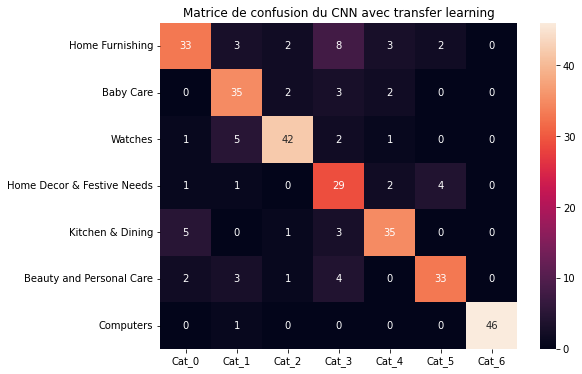

In [102]:
from sklearn.metrics import confusion_matrix, adjusted_rand_score
import seaborn as sns

y_pred = cnn_tl.predict(X_test)

y_predicted = []

for i in range(len(y_pred)):
    y_predicted.append(np.argmax(y_pred[i]))
    
cm = confusion_matrix(y_test, y_predicted)

plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True)
plt.yticks(np.arange(7)+0.5,list(tsn.cat.unique()), rotation='horizontal')
plt.xticks(np.arange(7)+0.5, ['Cat_' + str(i) for i in range(7)])
plt.title('Matrice de confusion du CNN avec transfer learning')
plt.savefig("cnn_tl_matrix.png", bbox_inches='tight', transparent=True)
plt.show()

In [103]:
adjusted_rand_score(y_test, y_predicted)

0.6068598594370144

##### [sommaire](#S)